### **Import necessary libraries**

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor

In [ ]:
df = pd.read_csv('../data/premiums.csv.csv')
df.head()

Age  Gender     Region Marital_status  Number Of Dependants BMI_Category  \
0   26    Male  Northwest      Unmarried                     0       Normal   
1   29  Female  Southeast        Married                     2      Obesity   
2   49  Female  Northeast        Married                     2       Normal   
3   30  Female  Southeast        Married                     3       Normal   
4   18    Male  Northeast      Unmarried                     0   Overweight   

  Smoking_Status Employment_Status Income_Level  Income_Lakhs  \
0     No Smoking          Salaried         <10L             6   
1        Regular          Salaried         <10L             6   
2     No Smoking     Self-Employed    10L - 25L            20   
3     No Smoking          Salaried        > 40L            77   
4        Regular     Self-Employed        > 40L            99   

       Medical History Insurance_Plan  Annual_Premium_Amount  
0             Diabetes         Bronze                   9053  
1             Diabetes         Bronze                  16339  
2  High blood pressure         Silver                  18164  
3           No Disease           Gold                  20303  
4  High blood pressure         Silver                  13365

In [18]:
df.shape

(50000, 13)

In [20]:
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.head()

age  gender     region marital_status  number_of_dependants bmi_category  \
0   26    Male  Northwest      Unmarried                     0       Normal   
1   29  Female  Southeast        Married                     2      Obesity   
2   49  Female  Northeast        Married                     2       Normal   
3   30  Female  Southeast        Married                     3       Normal   
4   18    Male  Northeast      Unmarried                     0   Overweight   

  smoking_status employment_status income_level  income_lakhs  \
0     No Smoking          Salaried         <10L             6   
1        Regular          Salaried         <10L             6   
2     No Smoking     Self-Employed    10L - 25L            20   
3     No Smoking          Salaried        > 40L            77   
4        Regular     Self-Employed        > 40L            99   

       medical_history insurance_plan  annual_premium_amount  
0             Diabetes         Bronze                   9053  
1             Diabetes         Bronze                  16339  
2  High blood pressure         Silver                  18164  
3           No Disease           Gold                  20303  
4  High blood pressure         Silver                  13365

### **Treat NA values**

In [21]:
df.isnull().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

Here, we can see some NA values. However, since the number of such rows is very small compared to the total number of rows, we can drop them.

In [22]:
df.dropna(inplace=True)
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

### **Check for row-level duplicacy**

In [23]:
df.duplicated().sum()

0

In [24]:
df.drop_duplicates(inplace=True) # Added to treat row level duplicacy (if occur in future, if this data set change/new dataset come)
df.duplicated().sum()

0

### **Exploratory data analysis (EDA) and data cleaning**

In [25]:
df.describe()

age  number_of_dependants  income_lakhs  annual_premium_amount
count  49976.000000          49976.000000  49976.000000           49976.000000
mean      34.591764              1.711842     23.021150           15766.810189
std       15.000378              1.498195     24.221794            8419.995271
min       18.000000             -3.000000      1.000000            3501.000000
25%       22.000000              0.000000      7.000000            8607.750000
50%       31.000000              2.000000     17.000000           13928.000000
75%       45.000000              3.000000     31.000000           22273.500000
max      356.000000              5.000000    930.000000           43471.000000

#### Univariate analysis: Numeric columns

In [26]:
columns_numeric = df.select_dtypes(include=['float64', 'int64']).columns
columns_numeric

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

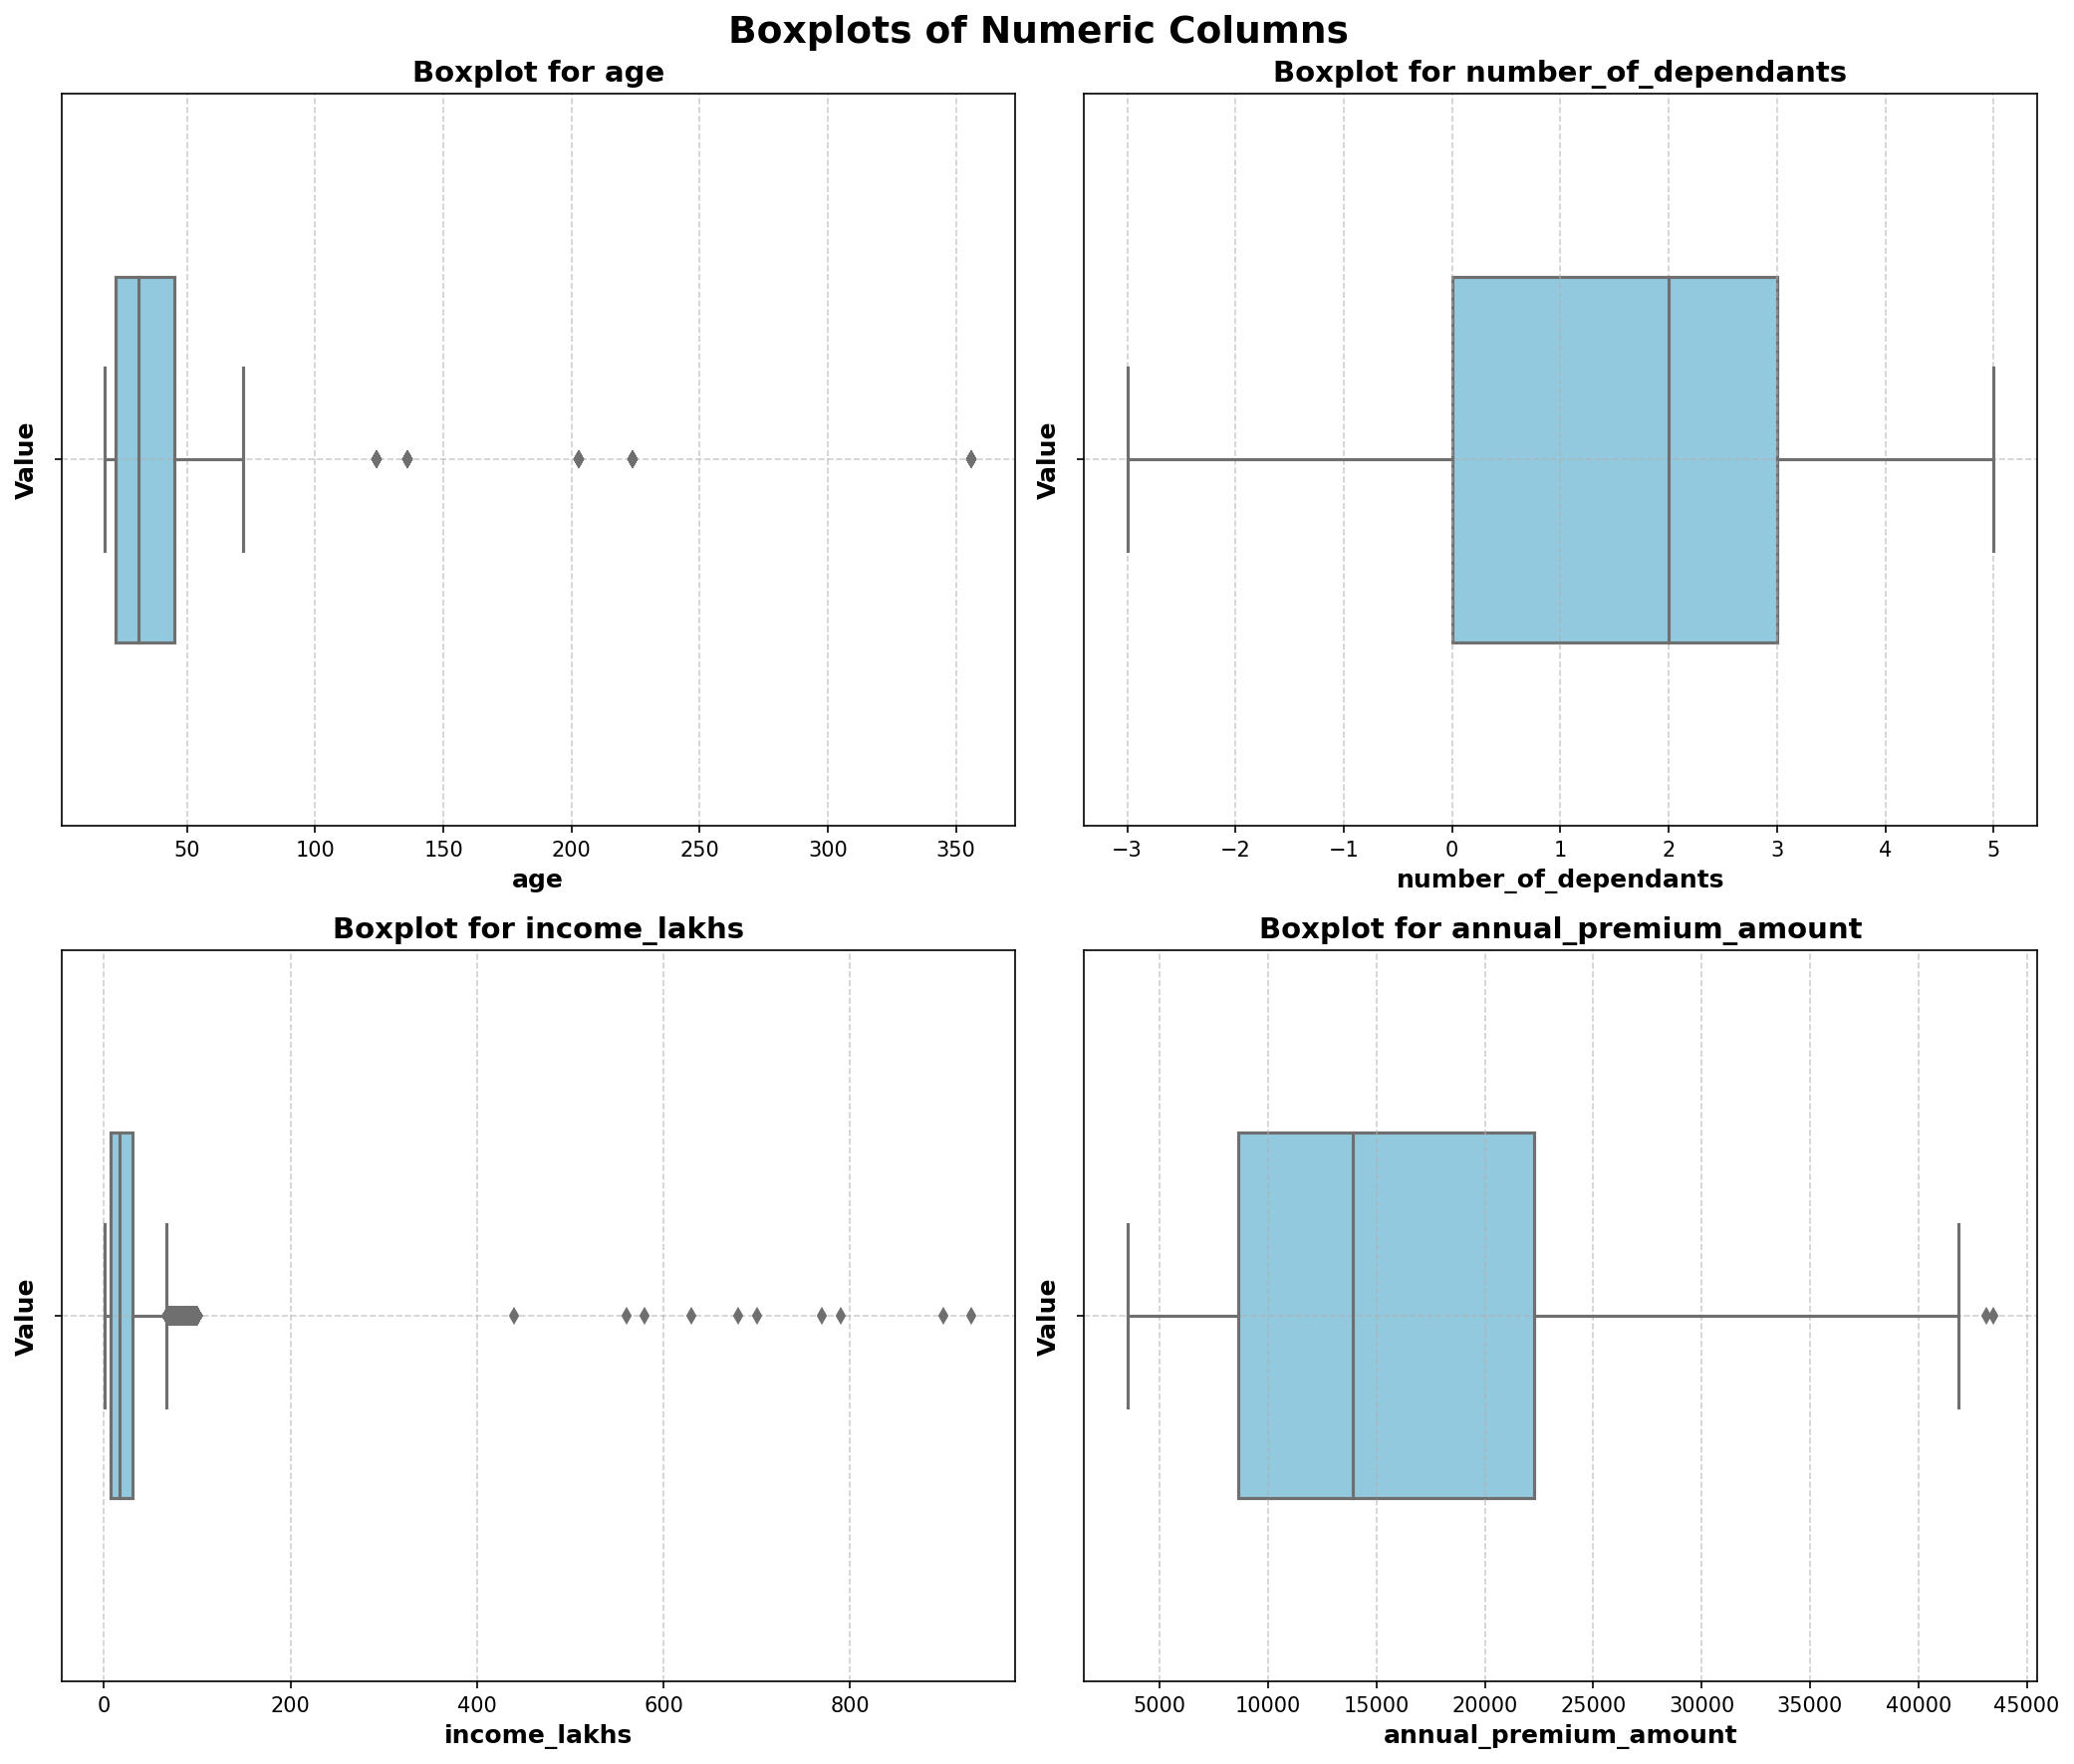

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12), dpi=150)
axes = axes.flatten()

for i, column in enumerate(columns_numeric[:4]):
    sns.boxplot(x=df[column], ax=axes[i], color='skyblue', width=0.5, linewidth=1.5)
    axes[i].set_title(f'Boxplot for {column}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(column, fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Value', fontsize=12, fontweight='bold')
    axes[i].grid(True, linestyle='--', alpha=0.6)

fig.suptitle('Boxplots of Numeric Columns', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

We can clearly see the outliers, except in the box plot for 'number_of_dependents'. Since 'number_of_dependents' cannot be negative, we need to treat those values. Additionally, we must address the outliers in the remaining box plots.

#### Handling outliers: age column

In [28]:
df[df.age > 100].shape

(58, 13)

In [29]:
df[df.age > 100].age.unique()

array([224, 124, 136, 203, 356], dtype=int64)

In [30]:
df1 = df[df.age <= 100].copy()
df1.age.describe()

count    49918.000000
mean        34.401839
std         13.681600
min         18.000000
25%         22.000000
50%         31.000000
75%         45.000000
max         72.000000
Name: age, dtype: float64

#### Data cleaning: number_of_dependants

In [31]:
df1[df1.number_of_dependants < 0].number_of_dependants.unique()

array([-3, -1], dtype=int64)

In [32]:
df1.number_of_dependants = df1.number_of_dependants.abs()
df1.number_of_dependants.describe()

count    49918.000000
mean         1.717617
std          1.492074
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

#### Handling outliers: income column

In [33]:
def iqr_bounds(column):
    q1, q3 = column.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return lower_bound, upper_bound

In [34]:
lower, upper = iqr_bounds(df['income_lakhs'])
lower, upper

(-29.0, 67.0)

In [35]:
df1[df1['income_lakhs']>upper].shape

(3559, 13)

We can see a significant number of valid records here. Modifying them in a real scenario may lead to overlooking the income. Therefore, we need to manually set an upper boundary threshold that covers most records.

In [36]:
threshold = 0.999
quantile_with_threshold = df1['income_lakhs'].quantile(0.999)
quantile_with_threshold

100.0

In [37]:
df1[df1.income_lakhs > quantile_with_threshold].shape

(10, 13)

In [38]:
df2 = df1[df1.income_lakhs <= quantile_with_threshold].copy()
df2.shape

(49908, 13)

In [39]:
df2.income_lakhs.describe()

count    49908.000000
mean        22.889897
std         22.170699
min          1.000000
25%          7.000000
50%         17.000000
75%         31.000000
max        100.000000
Name: income_lakhs, dtype: float64

In [40]:
df2.annual_premium_amount.describe()

count    49908.000000
mean     15765.739641
std       8418.674061
min       3501.000000
25%       8608.000000
50%      13928.000000
75%      22270.500000
max      43471.000000
Name: annual_premium_amount, dtype: float64

The maximum value of 'annual_premium_amount' appears reasonable, so we'll leave it as it is.

#### Bivariate analysis: Numeric columns

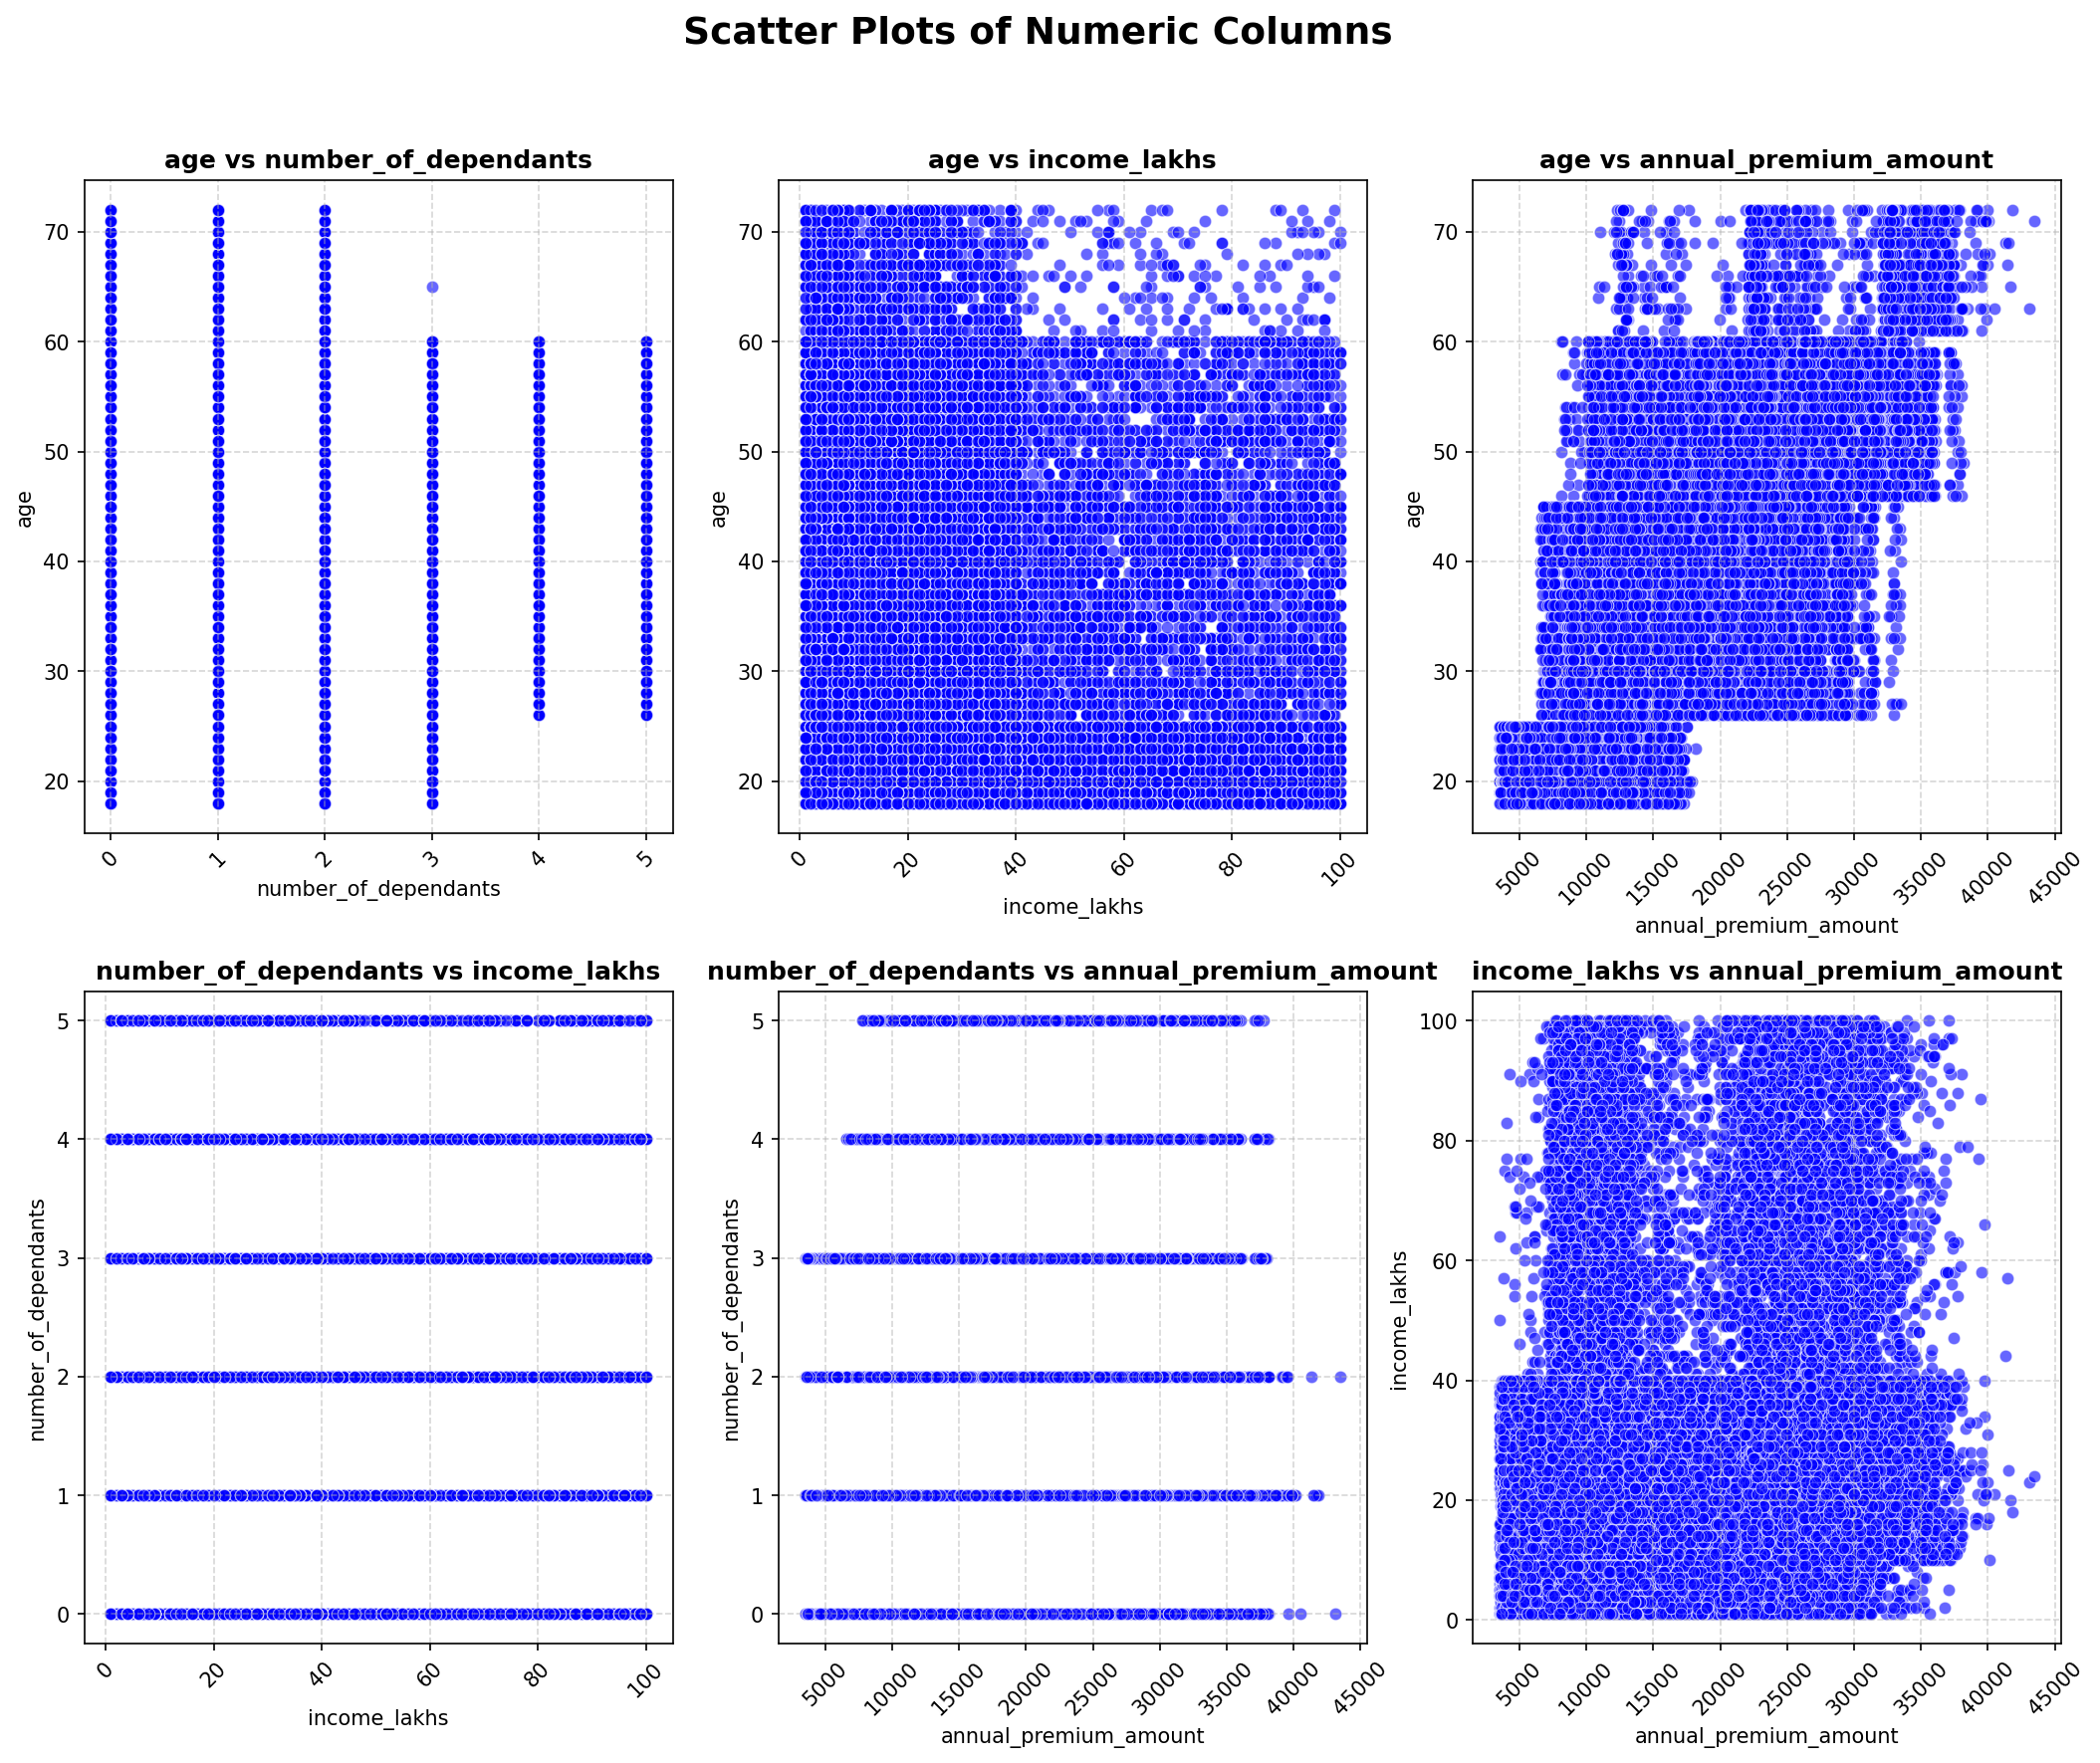

In [41]:
fig, axes = plt.subplots(2, 3, figsize=(14, 12), dpi=150)
fig.suptitle('Scatter Plots of Numeric Columns', fontsize=18, fontweight='bold')

plot_index = 0
total_plots = 6

for i, col_y in enumerate(columns_numeric):
    other_cols = columns_numeric[i+1:]
    for col_x in other_cols:
        row, col = divmod(plot_index, 3)
        sns.scatterplot(x=df2[col_x], y=df2[col_y], ax=axes[row, col], color='blue', alpha=0.6)
        axes[row, col].set_title(f'{col_y} vs {col_x}', fontsize=12, fontweight='bold')
        axes[row, col].set_xlabel(col_x, fontsize=10)
        axes[row, col].set_ylabel(col_y, fontsize=10)
        axes[row, col].grid(True, linestyle='--', alpha=0.5)
        axes[row, col].tick_params(axis='x', rotation=45)
        plot_index += 1

for i in range(plot_index, total_plots):
    row, col = divmod(i, 3)
    fig.delaxes(axes[row, col])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

For 'age' vs. 'annual_premium_amount', we can see a relationship where the amount increases as age increases. For the remaining plots, no clear bivariate relationship is observed.

#### Categorical columns

In [42]:
columns_categorical = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']
for column in columns_categorical:
    print(column, ":", df2[column].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [43]:
df2.smoking_status.replace({
    'Not Smoking': 'No Smoking',
    'Does Not Smoke': 'No Smoking',
    'Smoking=0': 'No Smoking'
}, inplace=True)

df2.smoking_status.unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

#### Univariate analysis

In [44]:
len(columns_categorical)

9

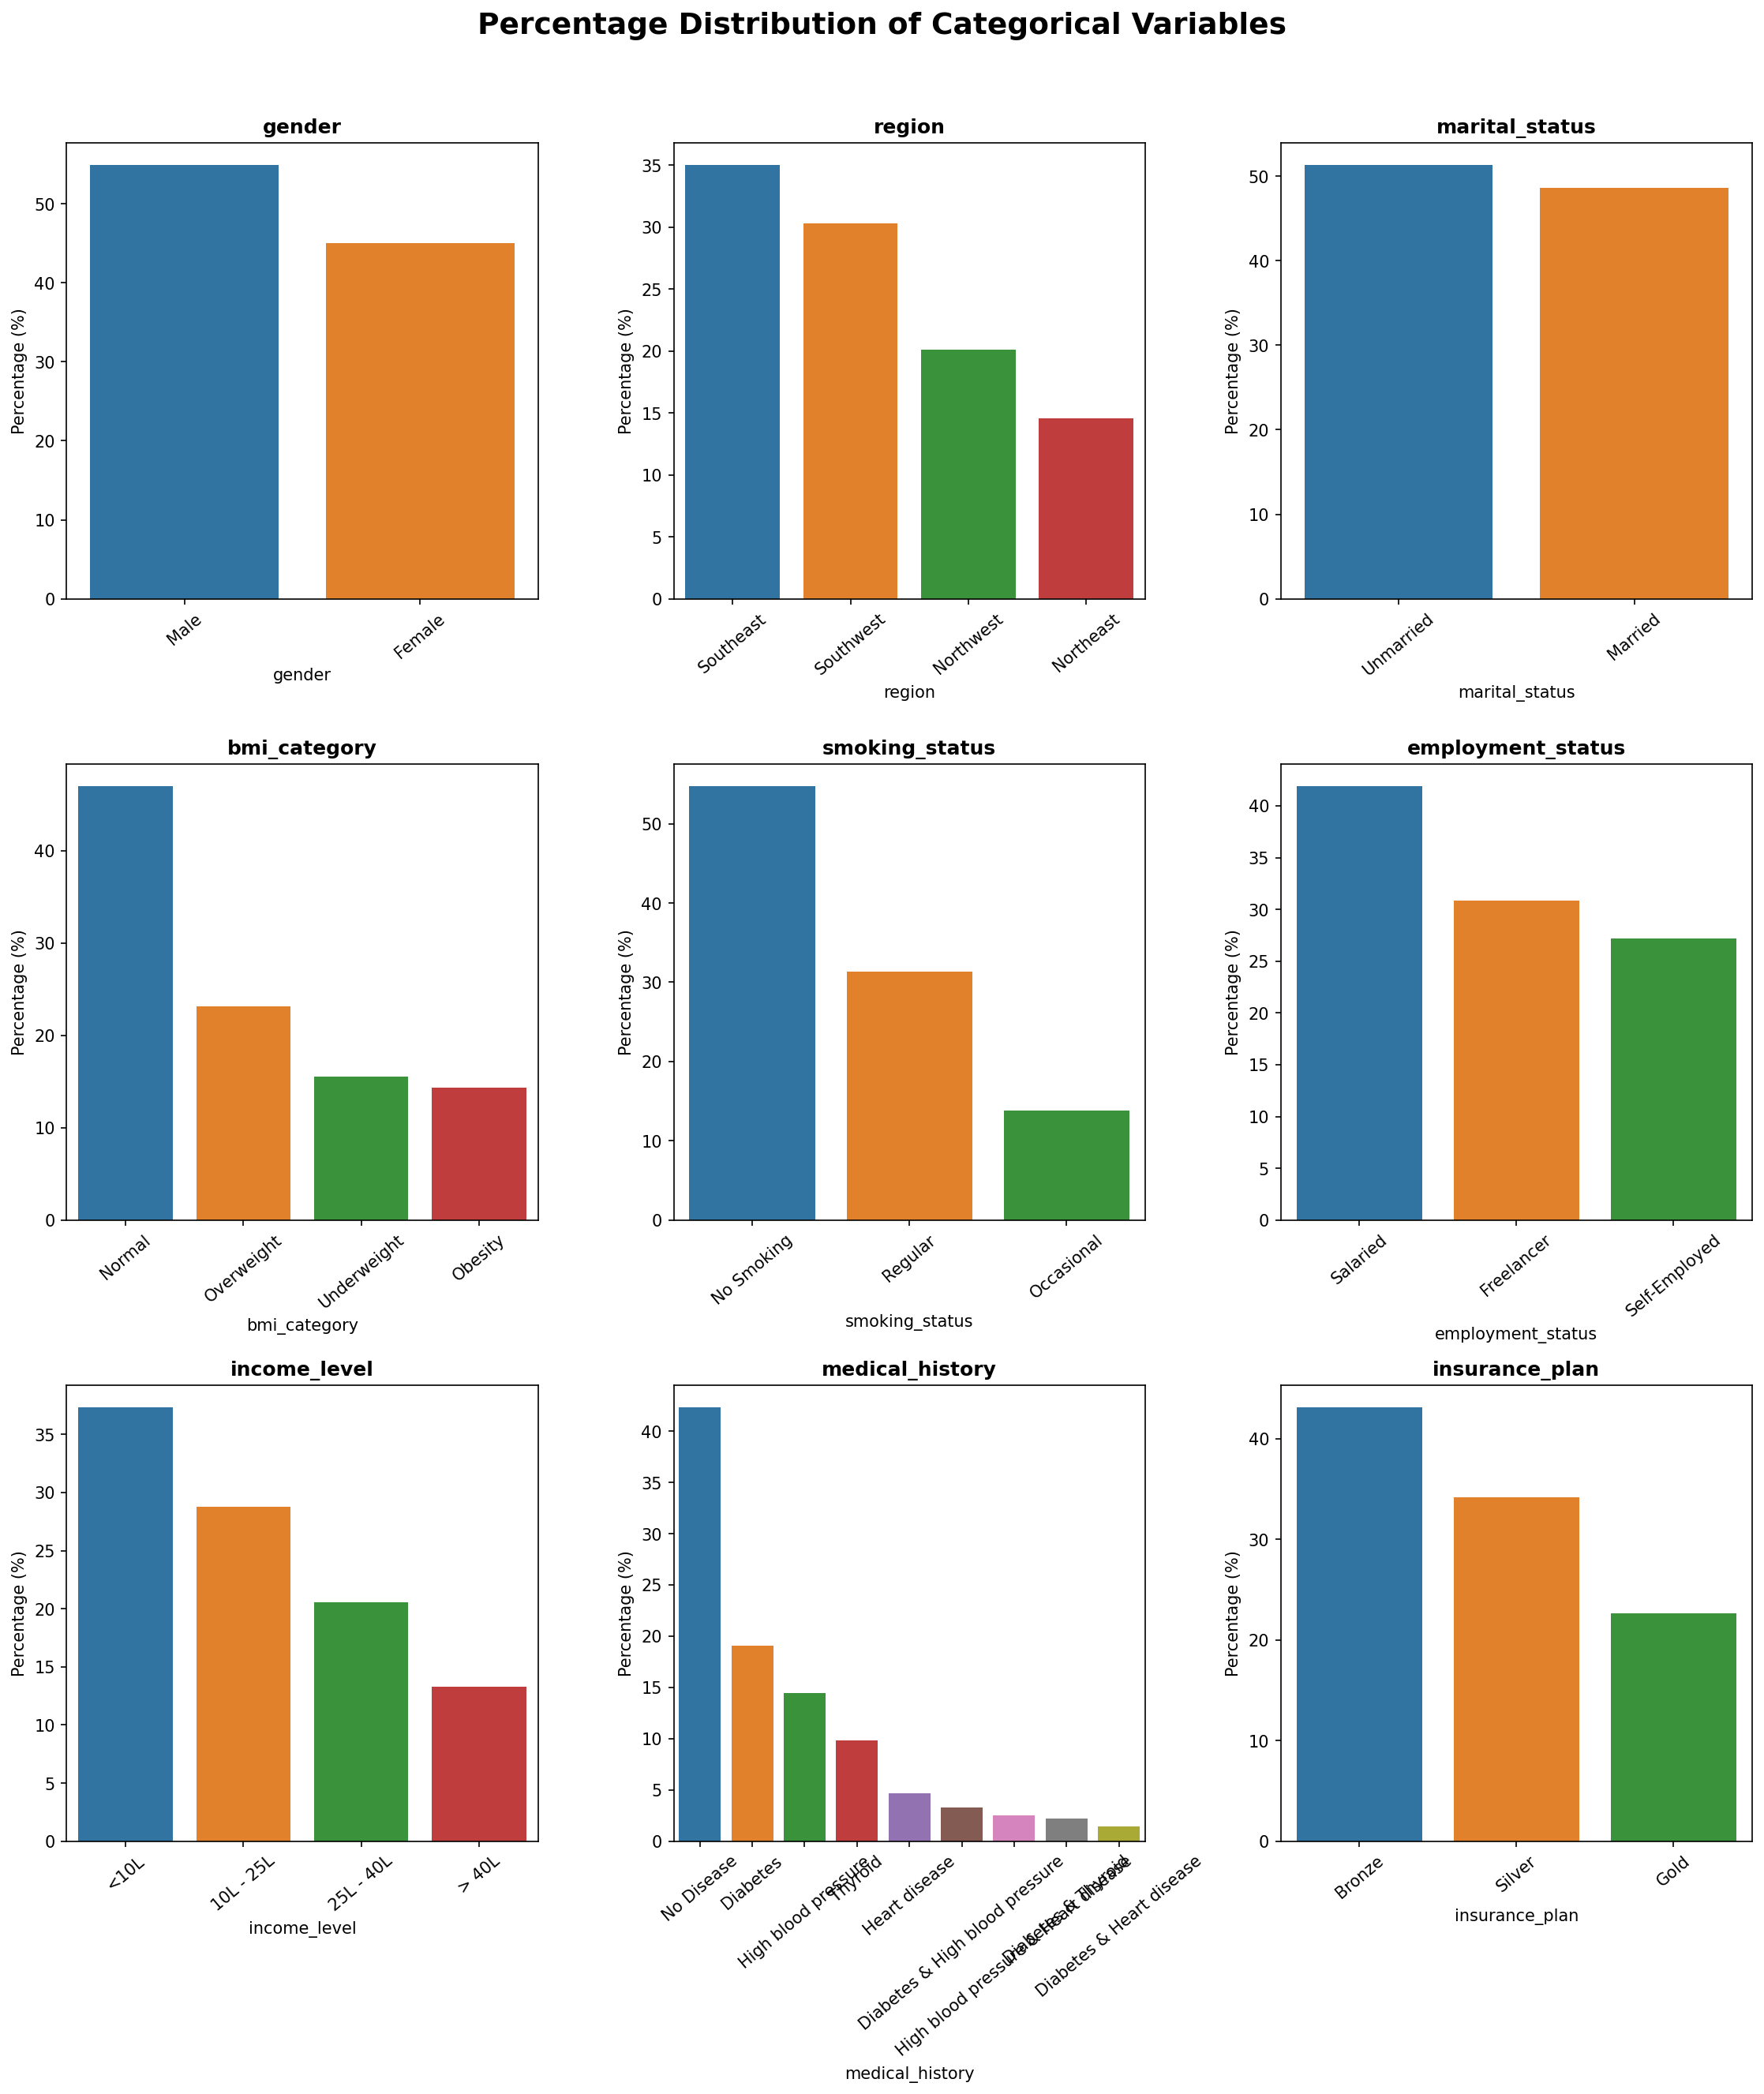

In [45]:
fig, axes = plt.subplots(3, 3, figsize=(15, 18), dpi=150)
fig.suptitle("Percentage Distribution of Categorical Variables", fontsize=18, fontweight='bold')

axes = axes.flatten()

for i, column in enumerate(columns_categorical):
    count_pct = df2[column].value_counts(normalize=True) * 100
    sns.barplot(x=count_pct.index, y=count_pct.values, ax=axes[i])
    axes[i].set_title(f'{column}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Percentage (%)')
    axes[i].set_xlabel(column)
    axes[i].tick_params(axis='x', rotation=40)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In all plots, the bars are arranged in descending order based on their percentages, making it easier to observe the data proportions and patterns. For instance, in the bar plot of 'region', most insurance plan buyers are from the southeast, while the fewest are from the northeast. Similarly, we can interpret the remaining plots.

#### Bivariate analysis

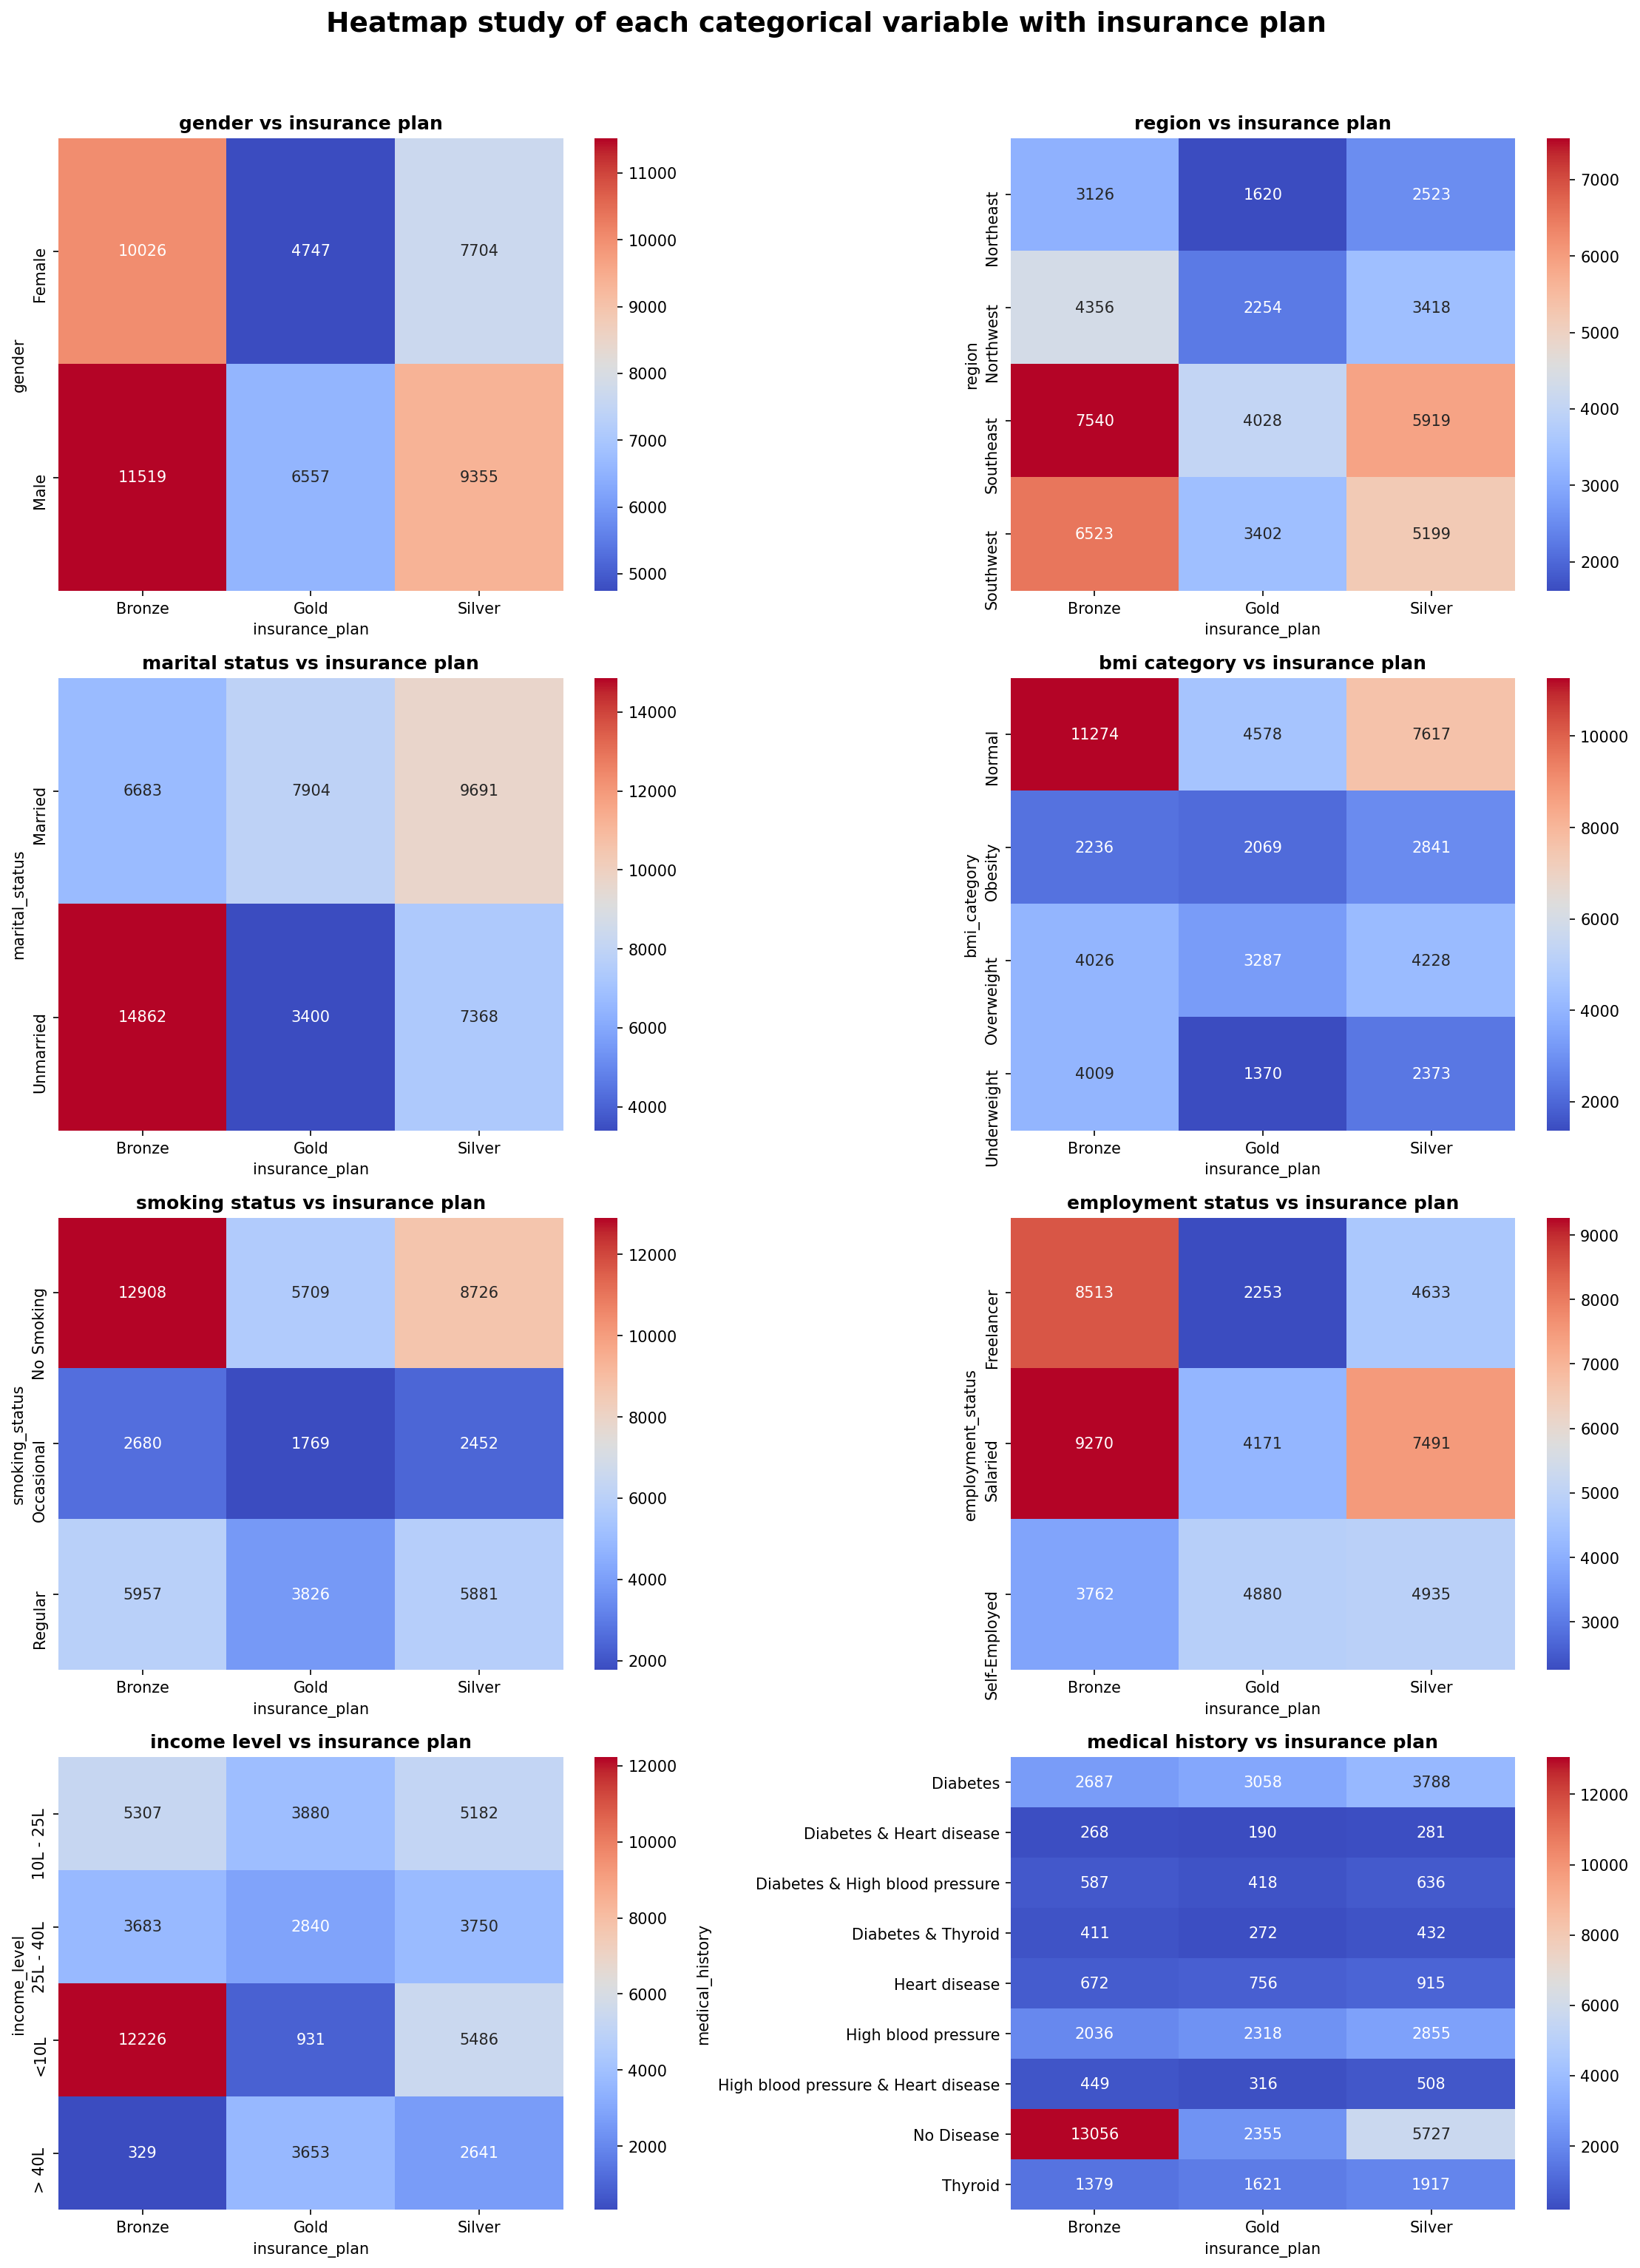

In [356]:
fig, axes = plt.subplots(4, 2, figsize=(15, 20), dpi=150)
fig.suptitle("Heatmap study of each categorical variable with insurance plan", fontsize=18, fontweight='bold', y=1.02)

axes = axes.flatten()  

for i, column in enumerate(columns_categorical):
    crosstab = pd.crosstab(df2[column], df2['insurance_plan'])
    try:
        sns.heatmap(crosstab, annot=True, cmap='coolwarm', fmt="d", ax=axes[i])
        axes[i].set_title(f'{column.replace("_", " ")} vs insurance plan', fontsize=12, fontweight='bold')
    except:
        pass
    

plt.tight_layout()
plt.show()

Here, we observe an interesting pattern: for each categorical variable, the bronze insurance plan is the most preferred. To encourage more people to choose the gold and silver plans, we may need to optimize them.

### **Feature Engineering**

In [46]:
# Manually assign risk scores for each condition
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df2[['disease1', 'disease2']] = df2.medical_history.str.split(" & ", expand = True).apply(lambda x: x.str.lower())

In [47]:
df2.isna().sum()

age                          0
gender                       0
region                       0
marital_status               0
number_of_dependants         0
bmi_category                 0
smoking_status               0
employment_status            0
income_level                 0
income_lakhs                 0
medical_history              0
insurance_plan               0
annual_premium_amount        0
disease1                     0
disease2                 45140
dtype: int64

In [48]:
df2['disease2'].fillna('none', inplace=True)

In [49]:
df2.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
disease1                 0
disease2                 0
dtype: int64

In [50]:
df2['total_risk_score'] = 0

In [51]:
for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

In [52]:
# Normalizing the risk score to a range of 0 to 1
max_score = df2.total_risk_score.max()
min_score = df2.total_risk_score.min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score)/(max_score - min_score)
df2.head()

age  gender     region marital_status  number_of_dependants bmi_category  \
0   26    Male  Northwest      Unmarried                     0       Normal   
1   29  Female  Southeast        Married                     2      Obesity   
2   49  Female  Northeast        Married                     2       Normal   
3   30  Female  Southeast        Married                     3       Normal   
4   18    Male  Northeast      Unmarried                     0   Overweight   

  smoking_status employment_status income_level  income_lakhs  \
0     No Smoking          Salaried         <10L             6   
1        Regular          Salaried         <10L             6   
2     No Smoking     Self-Employed    10L - 25L            20   
3     No Smoking          Salaried        > 40L            77   
4        Regular     Self-Employed        > 40L            99   

       medical_history insurance_plan  annual_premium_amount  \
0             Diabetes         Bronze                   9053   
1             Diabetes         Bronze                  16339   
2  High blood pressure         Silver                  18164   
3           No Disease           Gold                  20303   
4  High blood pressure         Silver                  13365   

              disease1 disease2  total_risk_score  normalized_risk_score  
0             diabetes     none                 6               0.428571  
1             diabetes     none                 6               0.428571  
2  high blood pressure     none                 6               0.428571  
3           no disease     none                 0               0.000000  
4  high blood pressure     none                 6               0.428571

#### Encode text columns

In [53]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})

In [54]:
df2.income_level.unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [55]:
df2['income_level'] = df2['income_level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})
columns_nominal = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns=columns_nominal, drop_first=True, dtype=int)
df3.head()

age  number_of_dependants  income_level  income_lakhs      medical_history  \
0   26                     0             1             6             Diabetes   
1   29                     2             1             6             Diabetes   
2   49                     2             2            20  High blood pressure   
3   30                     3             4            77           No Disease   
4   18                     0             4            99  High blood pressure   

   insurance_plan  annual_premium_amount             disease1 disease2  \
0               1                   9053             diabetes     none   
1               1                  16339             diabetes     none   
2               2                  18164  high blood pressure     none   
3               3                  20303           no disease     none   
4               2                  13365  high blood pressure     none   

   total_risk_score  ...  region_Southeast  region_Southwest  \
0                 6  ...                 0                 0   
1                 6  ...                 1                 0   
2                 6  ...                 0                 0   
3                 0  ...                 1                 0   
4                 6  ...                 0                 0   

   marital_status_Unmarried  bmi_category_Obesity  bmi_category_Overweight  \
0                         1                     0                        0   
1                         0                     1                        0   
2                         0                     0                        0   
3                         0                     0                        0   
4                         1                     0                        1   

   bmi_category_Underweight  smoking_status_Occasional  \
0                         0                          0   
1                         0                          0   
2                         0                          0   
3                         0                          0   
4                         0                          0   

   smoking_status_Regular  employment_status_Salaried  \
0                       0                           1   
1                       1                           1   
2                       0                           0   
3                       0                           1   
4                       1                           0   

   employment_status_Self-Employed  
0                                0  
1                                0  
2                                1  
3                                0  
4                                1  

[5 rows x 23 columns]

In [56]:
df3.shape

(49908, 23)

In [57]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49908 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              49908 non-null  int64  
 1   number_of_dependants             49908 non-null  int64  
 2   income_level                     49908 non-null  int64  
 3   income_lakhs                     49908 non-null  int64  
 4   medical_history                  49908 non-null  object 
 5   insurance_plan                   49908 non-null  int64  
 6   annual_premium_amount            49908 non-null  int64  
 7   disease1                         49908 non-null  object 
 8   disease2                         49908 non-null  object 
 9   total_risk_score                 49908 non-null  int64  
 10  normalized_risk_score            49908 non-null  float64
 11  gender_Male                      49908 non-null  int32  
 12  region_Northwest  

#### Feature selection

In [58]:
df4 = df3.drop(['medical_history','disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head()                

age  number_of_dependants  income_level  income_lakhs  insurance_plan  \
0   26                     0             1             6               1   
1   29                     2             1             6               1   
2   49                     2             2            20               2   
3   30                     3             4            77               3   
4   18                     0             4            99               2   

   annual_premium_amount  normalized_risk_score  gender_Male  \
0                   9053               0.428571            1   
1                  16339               0.428571            0   
2                  18164               0.428571            0   
3                  20303               0.000000            0   
4                  13365               0.428571            1   

   region_Northwest  region_Southeast  region_Southwest  \
0                 1                 0                 0   
1                 0                 1                 0   
2                 0                 0                 0   
3                 0                 1                 0   
4                 0                 0                 0   

   marital_status_Unmarried  bmi_category_Obesity  bmi_category_Overweight  \
0                         1                     0                        0   
1                         0                     1                        0   
2                         0                     0                        0   
3                         0                     0                        0   
4                         1                     0                        1   

   bmi_category_Underweight  smoking_status_Occasional  \
0                         0                          0   
1                         0                          0   
2                         0                          0   
3                         0                          0   
4                         0                          0   

   smoking_status_Regular  employment_status_Salaried  \
0                       0                           1   
1                       1                           1   
2                       0                           0   
3                       0                           1   
4                       1                           0   

   employment_status_Self-Employed  
0                                0  
1                                0  
2                                1  
3                                0  
4                                1

#### Calculating the Variance Inflation Factor (VIF) to detect multicollinearity

In [59]:
df4.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'normalized_risk_score',
       'gender_Male', 'region_Northwest', 'region_Southeast',
       'region_Southwest', 'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='object')

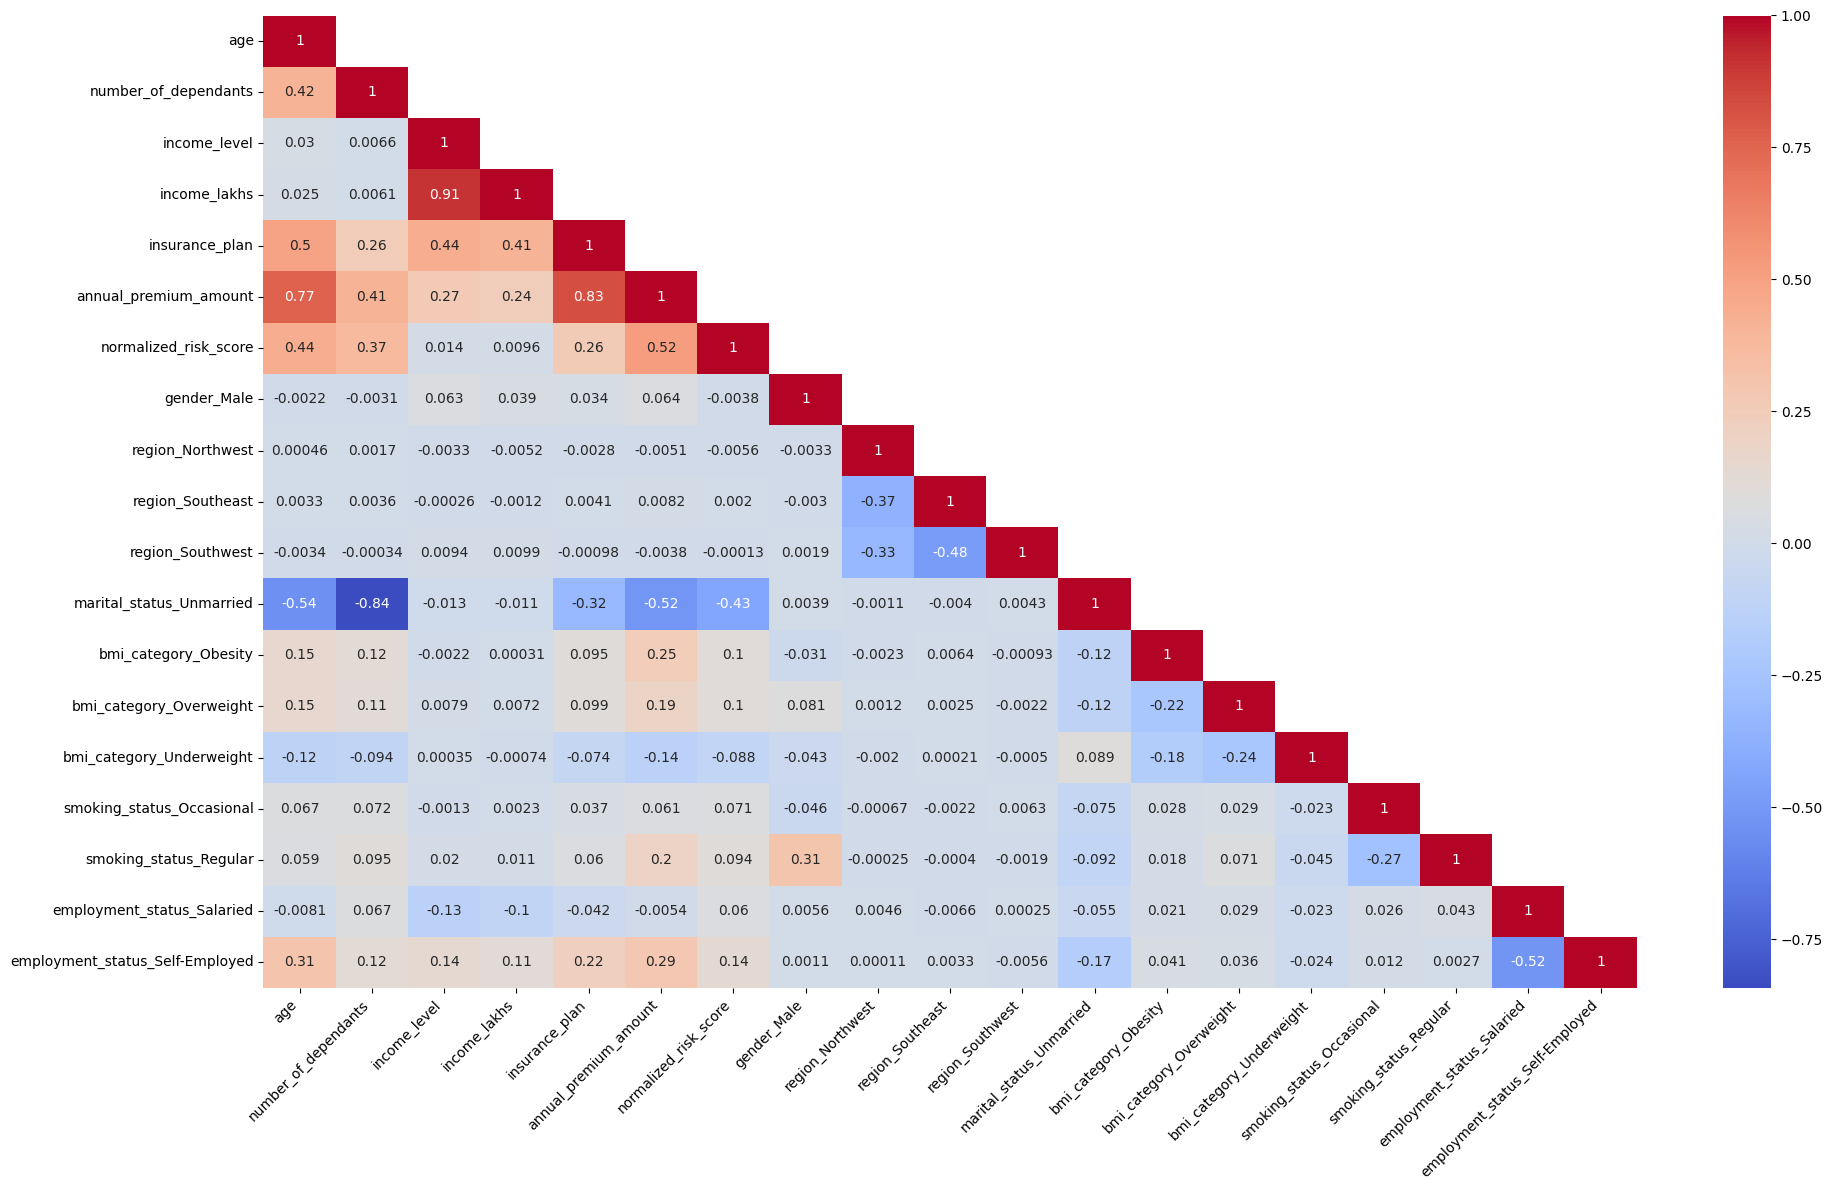

In [63]:
conf_matrix = df4.corr()

mask = np.triu(np.ones_like(conf_matrix, dtype=bool), k=1)

plt.figure(figsize=(20, 12))
sns.heatmap(conf_matrix, annot=True, mask=mask, cmap='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [64]:
X = df4.drop('annual_premium_amount', axis='columns')
y = df4['annual_premium_amount']

cols_to_scale = ['age','number_of_dependants', 'income_level',  'income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

age  number_of_dependants  income_level  income_lakhs  \
count  49908.000000          49908.000000  49908.000000  49908.000000   
mean       0.303733              0.343528      0.365900      0.221110   
std        0.253363              0.298406      0.349711      0.223946   
min        0.000000              0.000000      0.000000      0.000000   
25%        0.074074              0.000000      0.000000      0.060606   
50%        0.240741              0.400000      0.333333      0.161616   
75%        0.500000              0.600000      0.666667      0.303030   
max        1.000000              1.000000      1.000000      1.000000   

       insurance_plan  normalized_risk_score   gender_Male  region_Northwest  \
count    49908.000000           49908.000000  49908.000000       49908.00000   
mean         0.397401               0.291831      0.549631           0.20093   
std          0.392459               0.287420      0.497536           0.40070   
min          0.000000               0.000000      0.000000           0.00000   
25%          0.000000               0.000000      0.000000           0.00000   
50%          0.500000               0.357143      1.000000           0.00000   
75%          0.500000               0.428571      1.000000           0.00000   
max          1.000000               1.000000      1.000000           1.00000   

       region_Southeast  region_Southwest  marital_status_Unmarried  \
count      49908.000000      49908.000000              49908.000000   
mean           0.350385          0.303038                  0.513545   
std            0.477095          0.459576                  0.499822   
min            0.000000          0.000000                  0.000000   
25%            0.000000          0.000000                  0.000000   
50%            0.000000          0.000000                  1.000000   
75%            1.000000          1.000000                  1.000000   
max            1.000000          1.000000                  1.000000   

       bmi_category_Obesity  bmi_category_Overweight  \
count          49908.000000             49908.000000   
mean               0.143183                 0.231245   
std                0.350263                 0.421633   
min                0.000000                 0.000000   
25%                0.000000                 0.000000   
50%                0.000000                 0.000000   
75%                0.000000                 0.000000   
max                1.000000                 1.000000   

       bmi_category_Underweight  smoking_status_Occasional  \
count              49908.000000               49908.000000   
mean                   0.155326                   0.138274   
std                    0.362219                   0.345191   
min                    0.000000                   0.000000   
25%                    0.000000                   0.000000   
50%                    0.000000                   0.000000   
75%                    0.000000                   0.000000   
max                    1.000000                   1.000000   

       smoking_status_Regular  employment_status_Salaried  \
count            49908.000000                49908.000000   
mean                 0.313857                    0.419412   
std                  0.464064                    0.493468   
min                  0.000000                    0.000000   
25%                  0.000000                    0.000000   
50%                  0.000000                    0.000000   
75%                  1.000000                    1.000000   
max                  1.000000                    1.000000   

       employment_status_Self-Employed  
count                     49908.000000  
mean                          0.272041  
std                           0.445015  
min                           0.000000  
25%                           0.000000  
50%                           0.000000  
75%                           1.000000  
max                           1.000000

In [65]:
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

calculate_vif(X)

Column        VIF
0                               age   4.567634
1              number_of_dependants   4.534650
2                      income_level  12.450675
3                      income_lakhs  11.183367
4                    insurance_plan   3.584752
5             normalized_risk_score   2.687610
6                       gender_Male   2.421496
7                  region_Northwest   2.102556
8                  region_Southeast   2.922414
9                  region_Southwest   2.670666
10         marital_status_Unmarried   3.411185
11             bmi_category_Obesity   1.352806
12          bmi_category_Overweight   1.549922
13         bmi_category_Underweight   1.302886
14        smoking_status_Occasional   1.272745
15           smoking_status_Regular   1.777089
16       employment_status_Salaried   2.382134
17  employment_status_Self-Employed   2.137753

In [66]:
calculate_vif(X.drop('income_level', axis="columns"))

Column       VIF
0                               age  4.545825
1              number_of_dependants  4.526598
2                      income_lakhs  2.480563
3                    insurance_plan  3.445682
4             normalized_risk_score  2.687326
5                       gender_Male  2.409980
6                  region_Northwest  2.100789
7                  region_Southeast  2.919775
8                  region_Southwest  2.668314
9          marital_status_Unmarried  3.393718
10             bmi_category_Obesity  1.352748
11          bmi_category_Overweight  1.549907
12         bmi_category_Underweight  1.302636
13        smoking_status_Occasional  1.272744
14           smoking_status_Regular  1.777024
15       employment_status_Salaried  2.374628
16  employment_status_Self-Employed  2.132810

In [67]:
X_reduced = X.drop('income_level', axis="columns")

We dropped 'income_lakhs' due to its high VIF value, indicating strong multicollinearity with other variables.

### **Train the model**

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.30, random_state=10)
print(f"x train: {X_train.shape}\nx test: {X_test.shape}\ny train: {y_train.shape}\ny test: {y_test.shape}")

x train: (34935, 17)
x test: (14973, 17)
y train: (34935,)
y test: (14973,)


#### Linear regression

In [69]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score = model_lr.score(X_train, y_train)
train_score, test_score

(0.9282143576916762, 0.9280547230217837)

In [70]:
y_pred = model_lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print(f"MSE: {mse_lr}\nRMSE: {rmse_lr}")

MSE: 5165611.913027982
RMSE: 2272.798256121291


In [71]:
np.set_printoptions(suppress=True, precision=6)
model_lr.coef_

array([11160.926462,  -676.443991,  -514.229816, 12557.012936,
        4810.357702,   168.646662,   -35.719292,    39.96513 ,
         -24.652929,  -935.760611,  3387.911455,  1599.362268,
         391.171304,   735.912278,  2234.804712,   155.984674,
         415.903973])

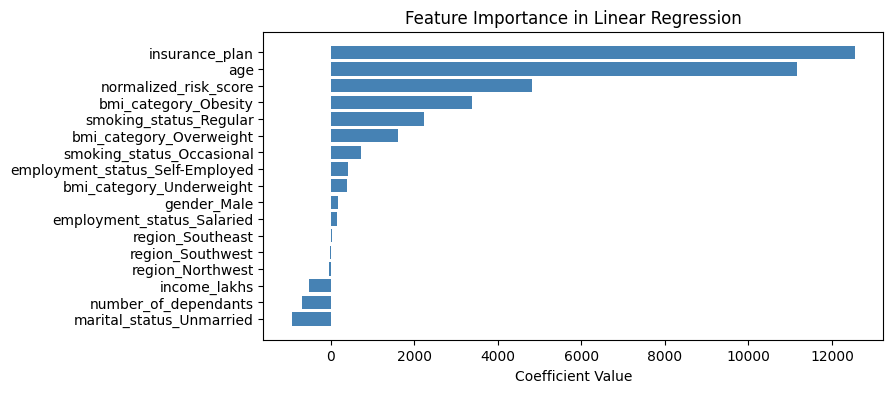

In [72]:
feature_importance = model_lr.coef_

coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

#### Ridge regression

In [73]:
model_rg = Ridge(alpha=1)
model_rg.fit(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score = model_rg.score(X_train, y_train)
train_score, test_score

(0.9282143198366275, 0.9280541644640345)

In [74]:
y_pred = model_rg.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print(f"MSE: {mse_lr}\nRMSE: {rmse_lr}")

MSE: 5165652.017016523
RMSE: 2272.8070787060924


#### XGBoost

In [75]:
model_xgb = XGBRegressor(n_estimators=20, max_depth=3)
model_xgb.fit(X_train, y_train)
model_xgb.score(X_test, y_test)

0.9782300559809473

In [76]:
y_pred = model_xgb.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print(f"MSE: {mse_lr}\nRMSE: {rmse_lr}")

MSE: 1563064.1356043513
RMSE: 1250.2256338774819


In [77]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_

0.9809474553641963

In [78]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

In [79]:
best_model = random_search.best_estimator_

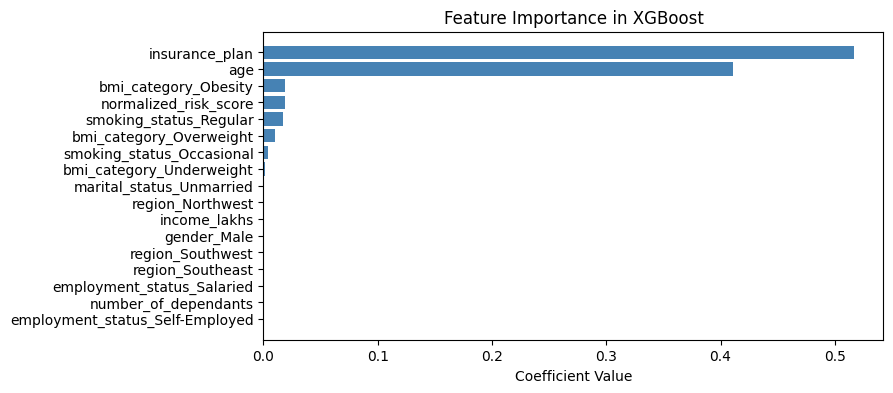

In [80]:
feature_importance = best_model.feature_importances_

coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

In [81]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = (residuals / y_test) * 100

results_df = pd.DataFrame({
    'actual': y_test, 
    'predicted': y_pred, 
    'diff': residuals, 
    'diff_pct': residuals_pct
})
results_df.head()

actual     predicted         diff   diff_pct
3598    20554  20334.953125  -219.046875  -1.065714
35794   29647  29378.779297  -268.220703  -0.904714
43608   20560  20618.185547    58.185547   0.283004
42730    5018   7352.829590  2334.829590  46.529087
18936    8929   8203.291992  -725.708008  -8.127540

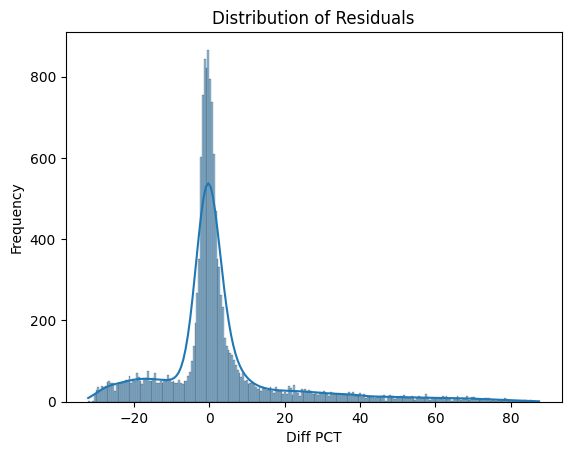

In [82]:
sns.histplot(results_df['diff_pct'], kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Diff PCT')
plt.ylabel('Frequency')
plt.show()

### **Error analysis**

In [83]:
extreme_error_threshold = 10
extreme_results_df = results_df[np.abs(results_df['diff_pct']) > extreme_error_threshold]
extreme_results_df.head()

actual     predicted         diff   diff_pct
42730    5018   7352.829590  2334.829590  46.529087
20029    5140   6670.849121  1530.849121  29.783057
4294     9631   7053.477539 -2577.522461 -26.762771
44419    4687   6670.849121  1983.849121  42.326629
6707     8826  10047.326172  1221.326172  13.837822

In [392]:
extreme_results_df.shape

(4487, 4)

In [393]:
extreme_errors_pct = extreme_results_df.shape[0]*100/X_test.shape[0]
extreme_errors_pct

29.967274427302478

We have 30% extreme errors, meaning that for 30% of customers, we will either overcharge or undercharge by 10% or more.

In [84]:
extreme_results_df[abs(extreme_results_df.diff_pct)>50].sort_values("diff_pct",ascending=False)

actual    predicted         diff   diff_pct
36269    3501  6565.852051  3064.852051  87.542189
48801    3516  6565.852051  3049.852051  86.742095
42342    3521  6565.852051  3044.852051  86.476911
18564    3523  6565.852051  3042.852051  86.371049
7988     3527  6565.852051  3038.852051  86.159684
...       ...          ...          ...        ...
32671    4656  6994.980957  2338.980957  50.235845
14798    4371  6565.852051  2194.852051  50.213957
13736    4371  6565.852051  2194.852051  50.213957
10107    4710  7073.240723  2363.240723  50.174962
16908    4699  7053.477539  2354.477539  50.105928

[549 rows x 4 columns]

Approximately 549 customers are expected to be overcharged or undercharged by more than 50%.

In [90]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

age  number_of_dependants  income_lakhs  insurance_plan  \
42730  0.092593                   0.2      0.131313             0.0   
20029  0.018519                   0.2      0.030303             0.0   
4294   0.000000                   0.2      0.020202             0.0   
44419  0.055556                   0.0      0.242424             0.0   
6707   0.111111                   0.2      0.070707             0.5   

       normalized_risk_score  gender_Male  region_Northwest  region_Southeast  \
42730               0.428571            1                 0                 0   
20029               0.000000            0                 1                 0   
4294                0.000000            1                 0                 0   
44419               0.000000            0                 0                 0   
6707                0.000000            1                 0                 0   

       region_Southwest  marital_status_Unmarried  bmi_category_Obesity  \
42730                 0                         1                     0   
20029                 0                         1                     0   
4294                  1                         1                     0   
44419                 0                         1                     0   
6707                  0                         1                     0   

       bmi_category_Overweight  bmi_category_Underweight  \
42730                        1                         0   
20029                        0                         1   
4294                         1                         0   
44419                        0                         1   
6707                         0                         1   

       smoking_status_Occasional  smoking_status_Regular  \
42730                          0                       0   
20029                          0                       0   
4294                           0                       0   
44419                          0                       0   
6707                           0                       0   

       employment_status_Salaried  employment_status_Self-Employed  
42730                           0                                0  
20029                           1                                0  
4294                            0                                0  
44419                           0                                0  
6707                            0                                0

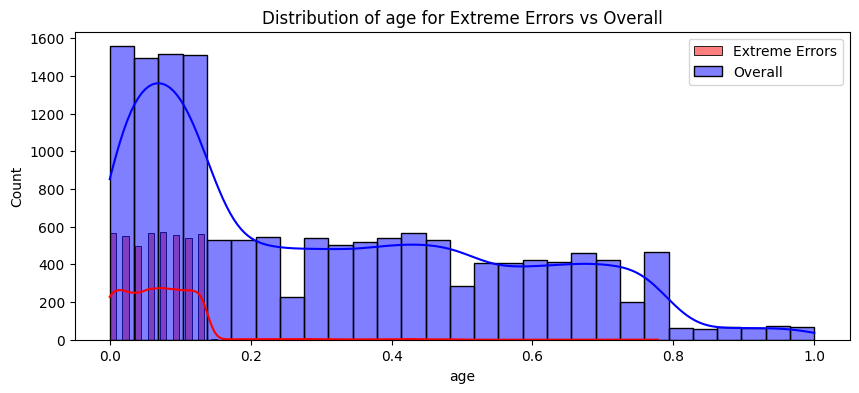

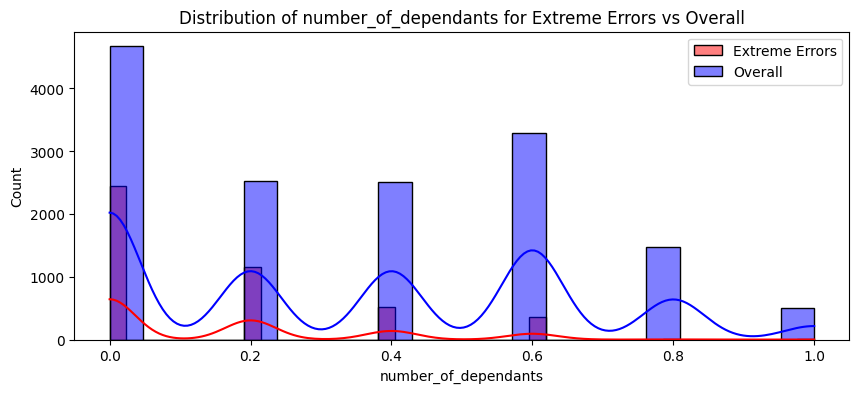

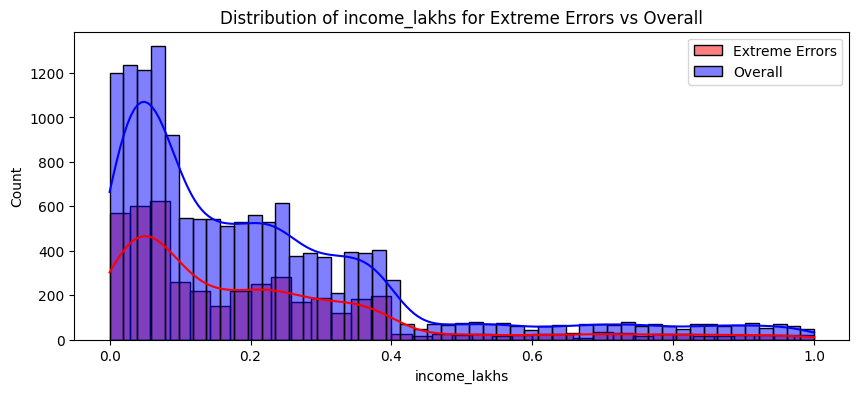

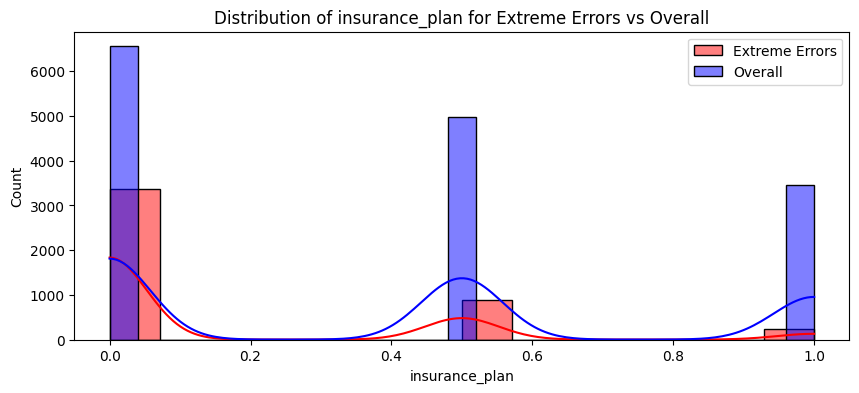

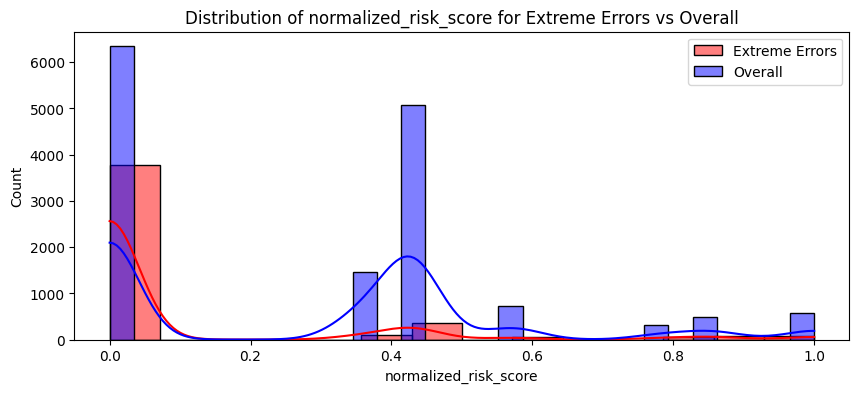

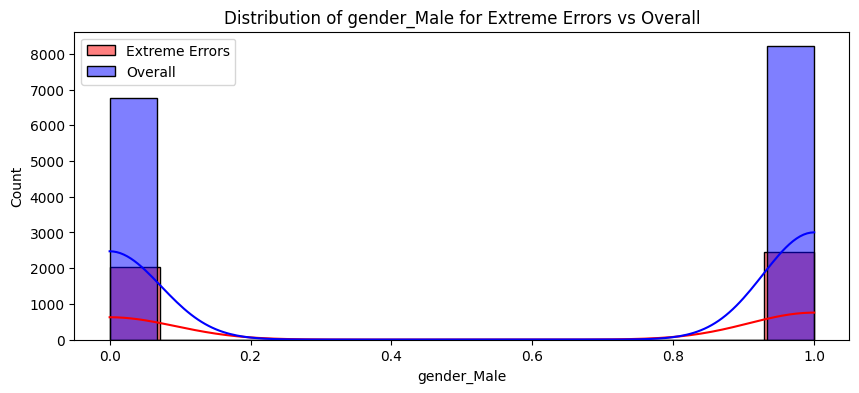

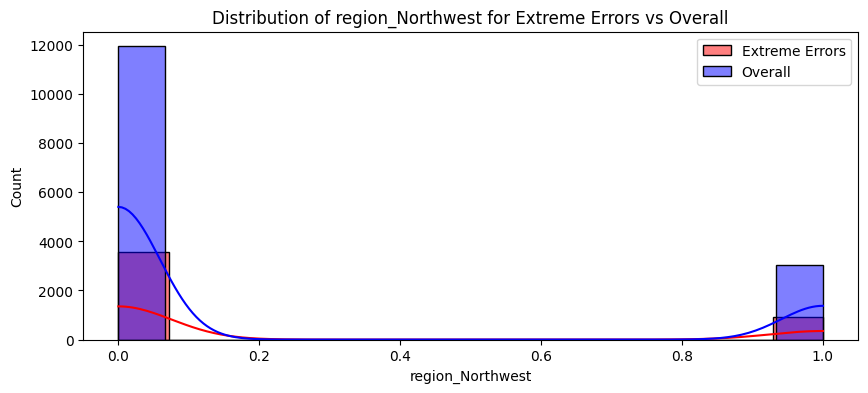

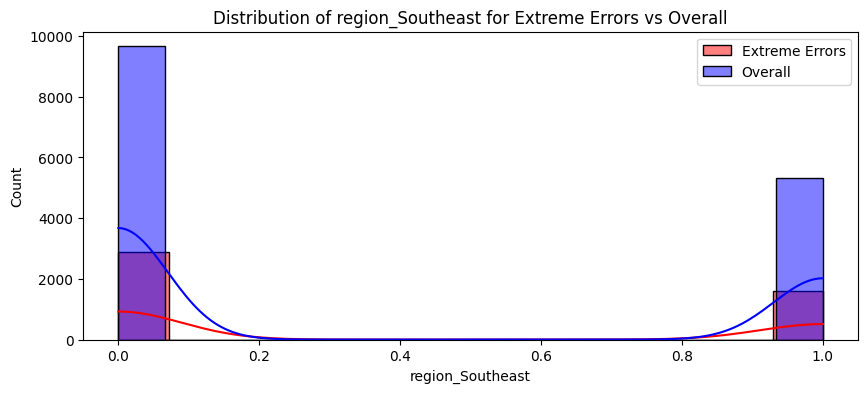

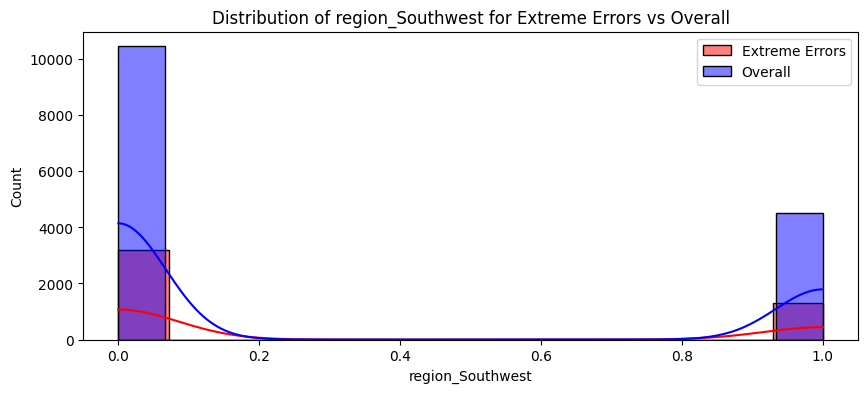

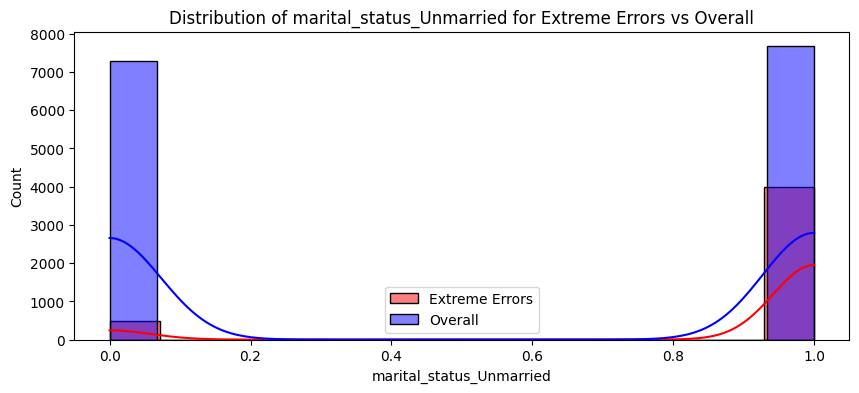

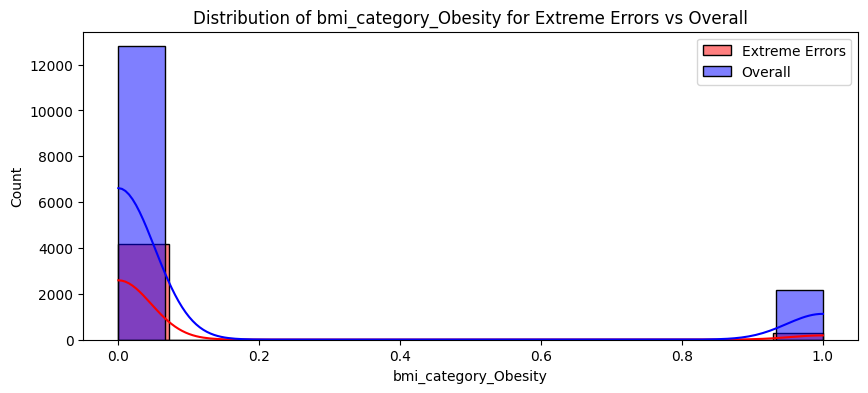

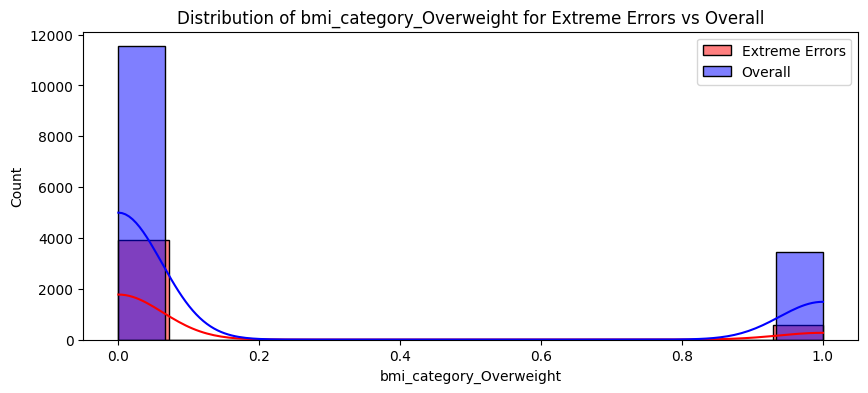

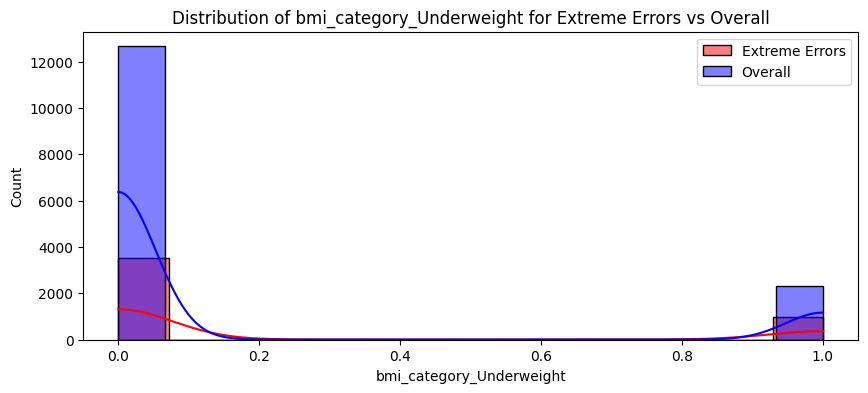

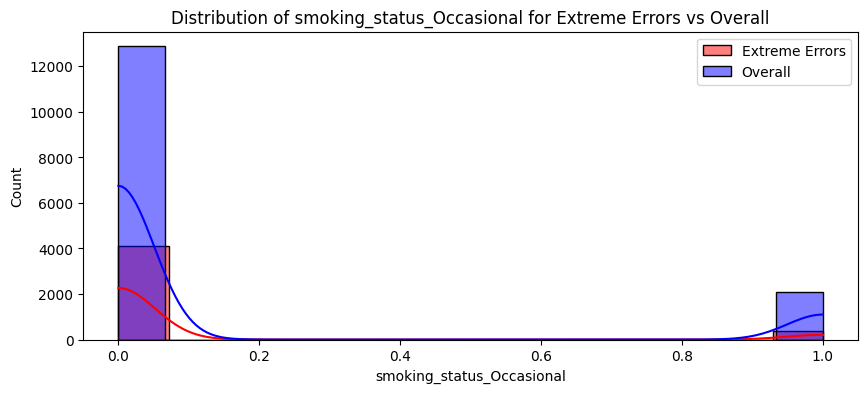

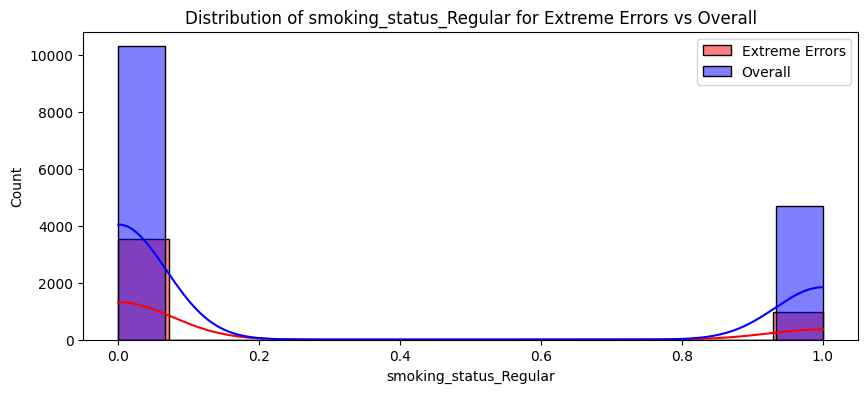

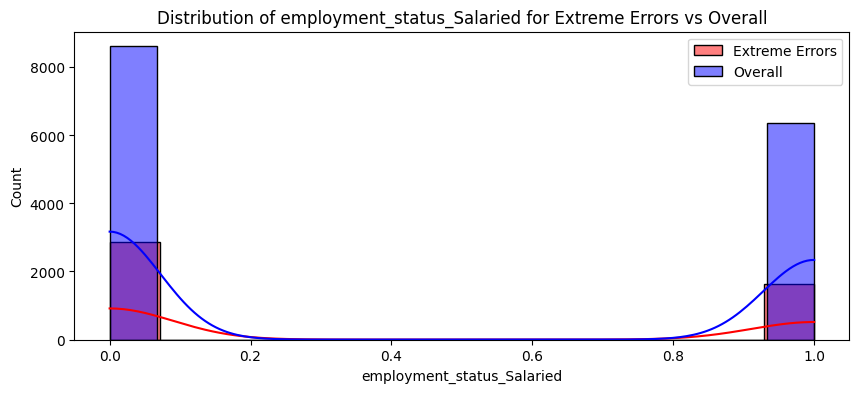

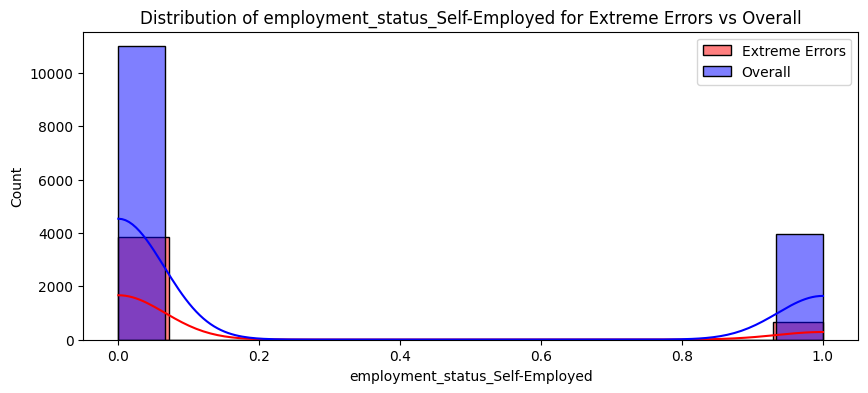

In [86]:
for feature in X_test.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(extreme_errors_df[feature], color='red', label='Extreme Errors', kde=True)
    sns.histplot(X_test[feature], color='blue', label='Overall', alpha=0.5, kde=True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()

### **Reverse Scaling**

In [87]:
extreme_errors_df['income_level']=-1

df_reversed = pd.DataFrame()
df_reversed = pd.DataFrame(
    scaler.inverse_transform(extreme_errors_df[cols_to_scale]),
    columns=cols_to_scale
)
df_reversed.head()

age  number_of_dependants  income_level  income_lakhs  insurance_plan
0  23.0                   1.0          -2.0          14.0             1.0
1  19.0                   1.0          -2.0           4.0             1.0
2  18.0                   1.0          -2.0           3.0             1.0
3  21.0                   0.0          -2.0          25.0             1.0
4  24.0                   1.0          -2.0           8.0             2.0

In [88]:
df_reversed.describe()

age  number_of_dependants  income_level  income_lakhs  \
count  4487.000000           4487.000000        4487.0   4487.000000   
mean     21.804992              0.739247          -2.0     21.182527   
std       3.172355              0.968855           0.0     20.598596   
min      18.000000              0.000000          -2.0      1.000000   
25%      20.000000              0.000000          -2.0      6.000000   
50%      22.000000              0.000000          -2.0     15.000000   
75%      24.000000              1.000000          -2.0     30.000000   
max      60.000000              5.000000          -2.0    100.000000   

       insurance_plan  
count     4487.000000  
mean         1.302429  
std          0.563135  
min          1.000000  
25%          1.000000  
50%          1.000000  
75%          1.000000  
max          3.000000

<AxesSubplot:xlabel='age', ylabel='Count'>

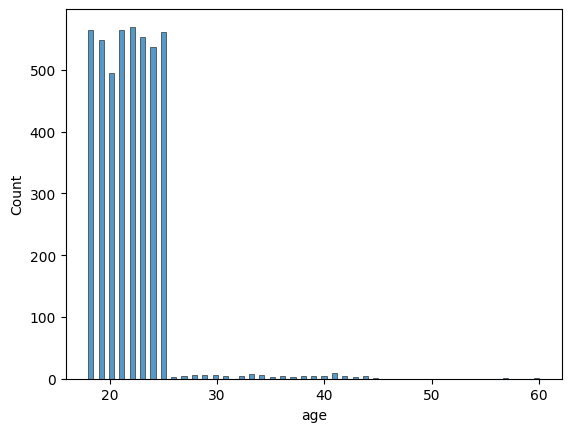

In [89]:
sns.histplot(df_reversed.age)

This shows that the majority of extreme errors come from the young age group (i.e., under 25 years old). To address this, we may need to build a separate model for this segment.

To proceed, we need to segment the current dataset (i.e., 'premiums.csv') into two parts as follows:
1. A dataset containing all data points with an age less than or equal to 25.
2. A dataset containing all data points with an age greater than 25.

Please refer to the '2_data_segment.ipynb' file for details on the data segmentation process.